In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Dense, Concatenate, Input, Lambda
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel

In [ ]:
# Dataset directory and class names
dataset_dir = "/content/drive/MyDrive/new clean"
class_names = ['Severe_cleaned', 'Unhealthy_cleaned', 'Unhealthy_for_Sensitive_Groups_cleaned', 'Very_Unhealthy_cleaned', 'good_cleaned', 'moderate_cleaned']

# Class name to label mapping
class_map = {class_name: idx for idx, class_name in enumerate(class_names)}

# List to store images and labels
images = []
labels = []

# Maximum number of images to load per class
max_images_per_class = 500

# Loading images and labels
for class_name in class_names:
    class_folder = os.path.join(dataset_dir, class_name)
    counter = 0
    for filename in os.listdir(class_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(class_folder, filename)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_map[class_name])
            counter += 1
            if counter >= max_images_per_class:
                break

# Converting images and labels to numpy arrays
images = np.array(images, dtype=np.float32) / 255.0  # Normalize images
labels = np.array(labels, dtype=np.int32)
labels = to_categorical(labels, num_classes=len(class_names))  # One-hot encode labels

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (2400, 224, 224, 3), Validation shape: (300, 224, 224, 3), Test shape: (300, 224, 224, 3)


In [ ]:
vit_model_name = "google/vit-base-patch16-224-in21k"
vit_model = TFAutoModel.from_pretrained(vit_model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
resnet_base = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Freezing ResNet layers
for layer in resnet_base.layers:
    layer.trainable = False

# Getting ResNet output
resnet_output = resnet_base.output
resnet_output = GlobalAveragePooling2D()(resnet_output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2400, 224, 224, 3)
Validation data shape: (300, 224, 224, 3)


In [ ]:
# ResNet output
resnet_output = resnet_base.output
resnet_output = GlobalAveragePooling2D()(resnet_output)

# ViT input
vit_input = Input(shape=(224, 224, 3))

# Resize and transpose for ViT
vit_preprocessed = Lambda(lambda x: tf.image.resize(x, (224, 224)))(vit_input)
vit_preprocessed_transposed = Lambda(lambda x: tf.transpose(x, perm=[0, 3, 1, 2]))(vit_preprocessed)

# Pass input through ViT
vit_output = Lambda(lambda x: vit_model(x, training=False).last_hidden_state)(vit_preprocessed_transposed)
vit_output = GlobalAveragePooling1D()(vit_output)

# Combine ResNet and ViT outputs
combined_output = Concatenate()([resnet_output, vit_output])

# Final dense layer for classification
final_output = Dense(len(class_names), activation='softmax')(combined_output)

# Define the model
model = Model(inputs=[resnet_base.input, vit_input], outputs=final_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,604,614 (90.04 MB)

 Trainable params: 16,902 (66.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [ ]:
history = model.fit(
    [X_train, X_train],
    y_train,
    validation_data=([X_val, X_val], y_val),
    batch_size=2,
    epochs=8
)
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')
final_training_loss = history.history["loss"][-1]
final_validation_loss = history.history["val_loss"][-1]
print(f"Training Loss: {final_training_loss:.4f}")
print(f"Validation Loss: {final_validation_loss:.4f}")

Epoch 1/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.6231 - loss: 1.0844 - val_accuracy: 0.8967 - val_loss: 0.3869
Epoch 2/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - accuracy: 0.9169 - loss: 0.3350 - val_accuracy: 0.9400 - val_loss: 0.2749
Epoch 3/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - accuracy: 0.9568 - loss: 0.2053 - val_accuracy: 0.9533 - val_loss: 0.1804
Epoch 4/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.9708 - loss: 0.1367 - val_accuracy: 0.9700 - val_loss: 0.1438
Epoch 5/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 87s 47ms/step - accuracy: 0.9836 - loss: 0.0987 - val_accuracy: 0.9700 - val_loss: 0.1263
Epoch 6/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 77s 43ms/step - accuracy: 0.9847 - loss: 0.0762 - val_accuracy: 0.9833 - val_loss: 0.1080
Epoch 7/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 87s 47ms/step - accuracy: 0.9873 - loss: 0.0700 - val_accuracy: 0.9733 - val_loss: 0.0977
Epoch 8/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.9915 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate([X_test, X_test], y_test, batch_size=2)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss :.2f}")

150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9714 - loss: 0.0910
Test Accuracy: 98.67%
Test loss: 0.06


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
# Define the batch prediction function
def predict_in_batches(model, X, batch_size=32):
    predictions = []
    for i in range(0, len(X[0]), batch_size):
        batch = [x[i:i+batch_size] for x in X]
        batch_predictions = model.predict(batch)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

batch_size = 32

# Predict in batches for the training set
y_train_pred_probs = predict_in_batches(model, [X_train, X_train], batch_size=batch_size)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# Convert true labels to class indices if they are one-hot encoded
y_train_true = np.argmax(y_train, axis=1)

# Print classification report
print("Training Classification Report:")
print(classification_report(y_train_true, y_train_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
y_val_pred = np.argmax(model.predict([X_val, X_val]), axis=1)
y_val_true = np.argmax(y_val, axis=1)
print("Validation Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Validation Classification Report:
                                        precision    recall  f1-score   support

                        Severe_cleaned       0.96      0.98      0.97        66
                     Unhealthy_cleaned       0.98      1.00      0.99        48
Unhealthy_for_Sensitive_Groups_cleaned       0.98      1.00      0.99        45
                Very_Unhealthy_cleaned       1.00      0.94      0.97        54
                          good_cleaned       0.95      0.95      0.95        41
                      moderate_cleaned       0.98      0.96      0.97        46

                              accuracy                           0.97       300
                             macro avg       0.97      0.97      0.97       300
                          weighted avg       0.97      0.97      0.97       300



In [ ]:
y_test_pred = np.argmax(model.predict([X_test, X_test]), axis=1)
y_test_true = np.argmax(y_test, axis=1)
print("Test Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step
Test Classification Report:
                                        precision    recall  f1-score   support

                        Severe_cleaned       0.98      0.98      0.98        52
                     Unhealthy_cleaned       1.00      0.98      0.99        51
Unhealthy_for_Sensitive_Groups_cleaned       0.98      1.00      0.99        51
                Very_Unhealthy_cleaned       1.00      1.00      1.00        47
                          good_cleaned       0.98      0.96      0.97        50
                      moderate_cleaned       0.98      1.00      0.99        49

                              accuracy                           0.99       300
                             macro avg       0.99      0.99      0.99       300
                          weighted avg       0.99      0.99      0.99       300



In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

train_metrics = precision_recall_fscore_support(y_train_true, y_train_pred, average='weighted')
val_metrics = precision_recall_fscore_support(y_val_true, y_val_pred, average='weighted')
test_metrics = precision_recall_fscore_support(y_test_true, y_test_pred, average='weighted')

print(f"Training Precision: {train_metrics[0]:.2f}, Recall: {train_metrics[1]:.2f}, F1-Score: {train_metrics[2]:.2f}")
print(f"Validation Precision: {val_metrics[0]:.2f}, Recall: {val_metrics[1]:.2f}, F1-Score: {val_metrics[2]:.2f}")
print(f"Test Precision: {test_metrics[0]:.2f}, Recall: {test_metrics[1]:.2f}, F1-Score: {test_metrics[2]:.2f}")

Training Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Validation Precision: 0.97, Recall: 0.97, F1-Score: 0.97
Test Precision: 0.99, Recall: 0.99, F1-Score: 0.99


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step


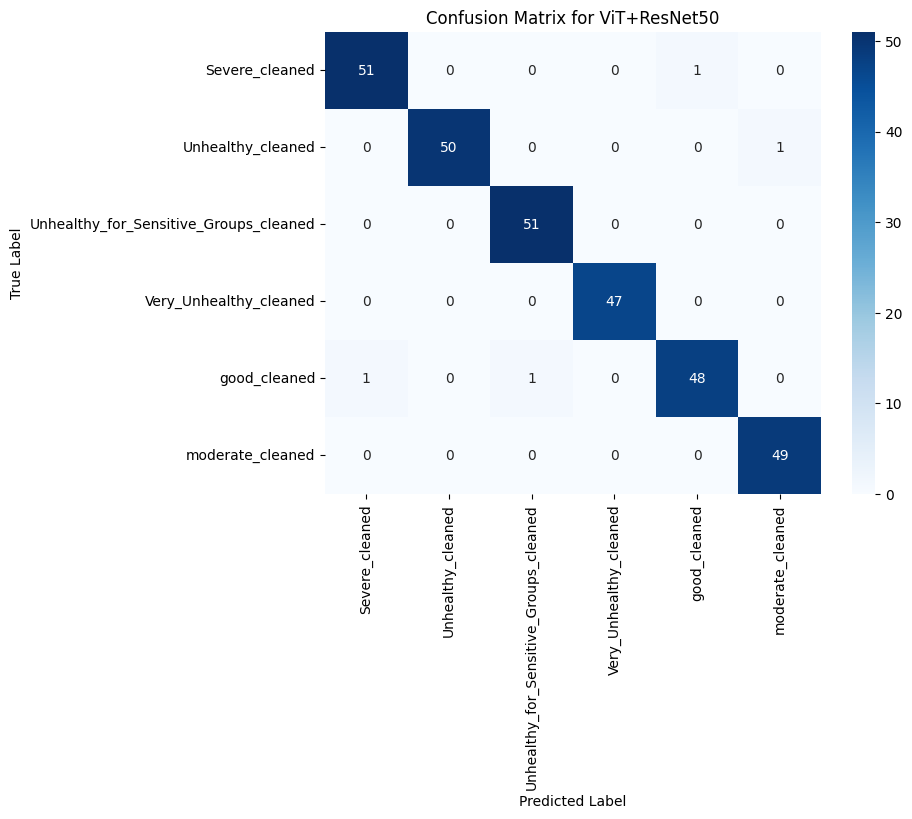

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict([X_test, X_test])
y_pred_class = np.argmax(y_pred, axis=1)

y_true_class = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for ViT+ResNet50')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
model.save("/content/resnet_vit_model.h5")

In [ ]:
from google.colab import files
files.download("/content/resnet_vit_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>